In [2]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP
from kuaizi.detection import Data
from kuaizi.utils import padding_PSF

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row
from astropy.coordinates import SkyCoord

from carpenter.display import display_merian_cutout_rgb

In [8]:
# import sys
# sys.path.append('/home/jiaxuanl/Research/Merian/merian_tractor/scripts/')
# # import mcf

In [9]:
env_dict = {'project': 'Merian', 'name': '', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)

'/scratch/gpfs/jiaxuanl/Data/Merian/'

In [10]:
kz.set_matplotlib(style='nature', usetex=False, dpi=80)

In [11]:
obj_cat = Table.read('./Cutout/magellan_spec/magellan_spec_obj_cat.fits')
cutout_cat = Table.read('./Cutout/magellan_spec/magellan_spec-2022-04-20.fits')

obj_cat['prefix'] = cutout_cat['prefix']
obj_cat['dir'] = cutout_cat['dir']
# obj_cat['dir'] = [file.replace('/projects/MERIAN/poststamps/g09_broadcut_new', 
#                               '/scratch/gpfs/jiaxuanl/Data/Merian/Cutout/_new/'
#                              ) for file in obj_cat['dir']]

In [12]:
channels = ['g', 'r', 'i', 'z', 'N708', 'N540']

obj = obj_cat[26] # 64 for slack example
obj_id = obj['id']

cutout = []
for filt in channels:
    if 'N' in filt:
        cutout.append(fits.open(os.path.join(obj['dir'], f"{obj['prefix']}_{filt}_deepCoadd_calexp.fits")))
    else:
        cutout.append(fits.open(os.path.join(obj['dir'], f's18a_wide_{obj["id"]}_{filt}.fits')))

psf_list = []
for filt in channels:
    if 'N' in filt:
        psf_list.append(fits.open(os.path.join(obj['dir'], f"{obj['prefix']}_{filt}_psf.fits")))
    else:
        psf_list.append(fits.open(os.path.join(obj['dir'], f's18a_wide_{obj["id"]}_{filt}_psf.fits')))

# Reconstruct data
images = np.array([hdu[1].data for hdu in cutout if len(hdu) > 1])
w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
filters = list(channels)
weights = 1 / np.array([hdu[3].data for hdu in cutout])
psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC
hsc_data = Data(images=images,
                masks=np.array([hdu[2].data for hdu in cutout if len(hdu) > 1]),
                weights=weights,
                wcs=w, psfs=psf_pad, channels=channels)

In [13]:
color_norm = {'g': 1.9, 'r': 1.2, 'i': 1.0,
              'z': 0.85, 'y': 0.5, 'N708': 1.1, 'N540': 1.0}

Text(0.5, 1.0, 'N708')

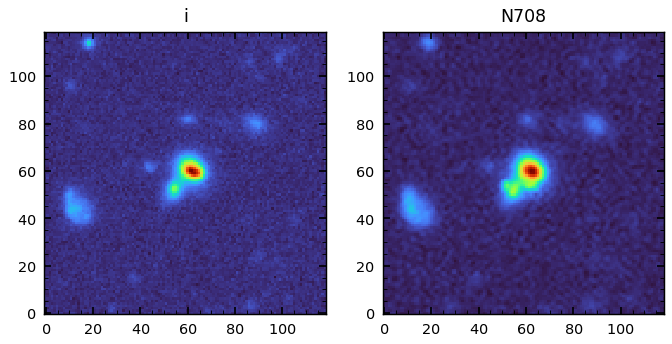

In [14]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(hsc_data.images[2])
ax1.set_title('i')
ax2.imshow(hsc_data.images[-2])
ax2.set_title('N708')

Text(0.5, 1.0, 'HSC griz')

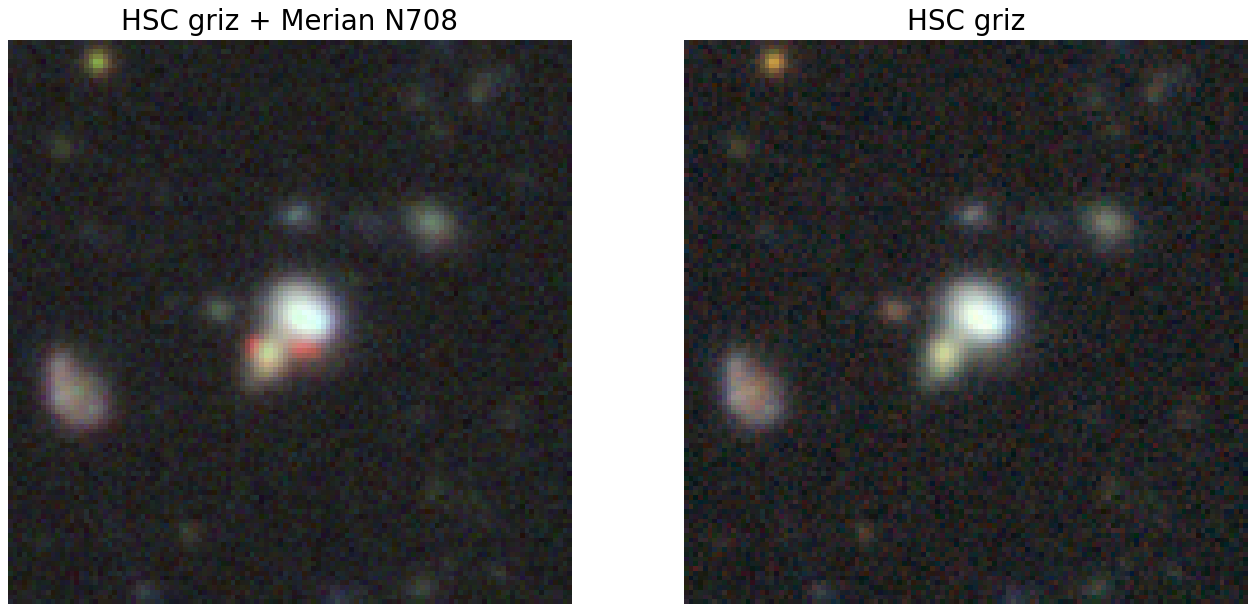

In [17]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))

_img = hsc_data.images
_, img_rgb = display_merian_cutout_rgb(_img, filters=list('griz') + ['N708', 'N540'], 
                          ax=ax1, color_norm=color_norm, 
                          channel_map=None, N708_strength=3);
ax1.set_title('HSC griz + Merian N708', fontsize=25)

_img = hsc_data.images[0:4]
_, _ = display_merian_cutout_rgb(_img, filters=list('griz'), ax=ax2, 
                                       color_norm=color_norm,
                                       channel_map=None);

ax2.set_title('HSC griz', fontsize=25)

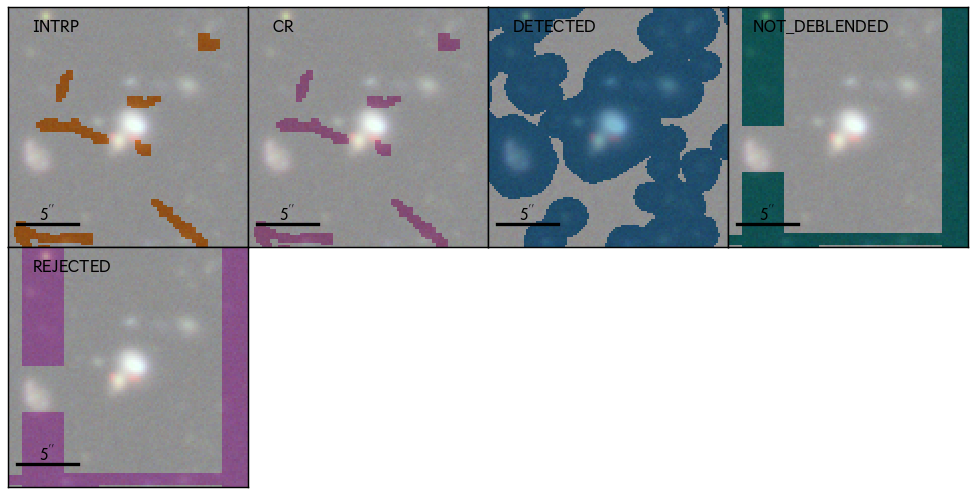

In [18]:
from unagi import mask
bitmask = hsc_data.masks[-2]
mask_test = mask.Mask(bitmask, data_release='s20a')
fig, mm = mask_test.show_used()

for ax in fig.get_axes():
    ax.imshow(img_rgb, alpha=0.5)

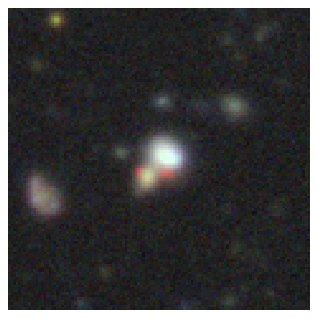

In [20]:
fig, ax = plt.subplots(figsize=(5, 5))

_img = hsc_data.images
display_merian_cutout_rgb(_img, filters=list('griz') + ['N708', 'N540'], 
                          ax=ax, color_norm=color_norm, N708_strength=2.0,
                          channel_map=None);

# plt.savefig(f'/tigress/jiaxuanl/public_html/Merian/cutout_RGB/magellan_cosmos_{obj["name"]}_HSC_N708.png', 
#             bbox_inches='tight', dpi=70, transparent=True, pad_inches=0)
# plt.close()

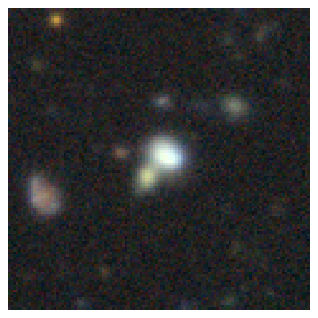

In [21]:
fig, ax = plt.subplots(figsize=(5, 5))

_img = hsc_data.images[:4]
display_merian_cutout_rgb(_img, filters=list('griz'),
                          ax=ax, color_norm=color_norm,
                          channel_map=None);

# plt.savefig(f'/tigress/jiaxuanl/public_html/Merian/cutout_RGB/magellan_cosmos_{obj["name"]}_HSC.png', 
#             bbox_inches='tight', dpi=70, transparent=True, pad_inches=0)

In [32]:
tractor_cat = Table.read('./Catalogs/magellan/tractor_magellan_output_all.fits')
tractor_cat.sort('ID')
tractor_cat['re'] /= 0.168
tractor_cat['re_ivar'] /= 0.168**2

In [33]:
from astropy.cosmology import Planck15
obj_cat['re_ang'] = tractor_cat['re']
obj_cat['re_phys'] = (Planck15.angular_diameter_distance(obj_cat['redshift']) * obj_cat['re_ang'] / 206265
                     ).to(u.kpc).value

In [34]:
obj_cat[(obj_cat['redshift'] < 0.12) & (obj_cat['redshift'] > 0.04)
       ][['id', 'ra', 'dec', 'redshift', 're_ang', 're_phys']].write(
    '/tigress/jiaxuanl/public_html/galary/catalogs/magellan_spec/viz_cat_0p04_0p12.txt', 
                                   format='ascii')